## 1. Introduction

Welcome to Stage 2 of the Twitter Sentiment Analysis project. Building upon the foundational work laid out in Stage 1, this segment delves deeper into the practical application of sentiment analysis, employing two powerful and competing models: Naive Bayes and BERT (Bidirectional Encoder Representations from Transformers). In this stage, we aim to rigorously compare and analyze the performance, nuances, and outcomes of using these models on the preprocessed Twitter data set.

### 1.1 Recap of Stage 1

In Stage 1, titled "Twitter Sentiment Analysis Naive Bayes BERT Stage 1," we focused on setting up the necessary environment, retrieving and preprocessing the Twitter data, conducting exploratory data analysis, and preparing the text data for modeling. We ensured that the data was clean, structured, and ready for advanced analysis. The insights and processed data from Stage 1 form the bedrock upon which we build our comparative analysis in this stage.


### 1.2 Objectives of Stage 2


* **Implementing Models:** Implementing BERT and Naive Bayes models to perform sentiment analysis on the Twitter data.
* **Performance Comparison:** Comparing the accuracy, efficiency, and other relevant metrics between the models to understand their strengths and weaknesses in the context of sentiment analysis.
* **Insightful Analysis:** Drawing insights from the models' predictions to understand sentiment trends, patterns, and anomalies within the Twitter data.
* **Optimization and Tuning:** Fine-tuning the models and optimizing parameters to achieve the best performance.

## 2. Environment Setup


### 2.1 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from transformers import BertTokenizerFast
from transformers import TFBertModel

from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix

### 2.2 Mount Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


### 2.4 Utility Functions - Custom Classification Report

In [3]:
# Labels for matrix axes
labels = ['Negative', 'Neutral', 'Positive']

def conf_matrix(y, y_pred, title):
    # Initialize plotting space
    fig, ax = plt.subplots(figsize=(6, 3))

    # Generate and visualize confusion matrix
    sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":12})

    # Configure aesthetics and layout
    plt.title(title, fontsize=15)
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticklabels(labels, fontsize=10)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    plt.tight_layout()
    plt.show()

In [4]:
def custom_report(y_true, y_pred, class_names):
    # Generate the classification report with output_dict=True to get it as a dictionary
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    # Calculate the accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Initialize an empty string to store your custom report
    custom_report_str = "              precision    recall  f1-score   support\n\n"

    # Iterate through each item in the report and format it
    for label, metrics in report_dict.items():
        if label in class_names:  # Ensure to process only your specific class names
            # Format each row
            custom_report_str += f"    {label:<9}    {metrics['precision']:.2f}      {metrics['recall']:.2f}      {metrics['f1-score']:.2f}      {metrics['support']:>5}\n"

    # Append the accuracy to the report string
    custom_report_str += f"\n    {'Accuracy':<9}    {accuracy:.2f}\n"

    print(custom_report_str)

## 3. Data Loading and Preprocessing Section


### 3.1 Loading the cleaned dataset


In [5]:
# Load the cleaned training data
train_os = pd.read_csv('/content/drive/My Drive/Cleaned_Training_Data.csv')

# Load the cleaned test data
df_test = pd.read_csv('/content/drive/My Drive/Cleaned_Test_Data.csv')

### 3.2 Splitting the dataset

In [6]:
# Define data and labels
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

# Setting random seed for reproducibility
seed = 42

# Splitting the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

*You might wonder why I used seed = 42, simply to ensure consistent, reproducible results in random processes by the way number 42 is an arbitrary yet popular choice, often used for its cultural reference.*

In [7]:
print(f"Training data ---> {X_train.shape[0]}\nValidation data -> {X_valid.shape[0]}\nTesting data ----> {X_test.shape[0]}" )

Training data ---> 48600
Validation data -> 5400
Testing data ----> 3792


*The distribution of the data is approximately 90% for training data and 10% for validation data.*

## 4. Machine Learning - Naive Bayes

### 4.1 Preparing Target Variables - One-Hot Encoding

*You might notice we're working with three labels: Negative, Neutral, and Positive. Since this isn't a binary classification, we needed a suitable method. One hot encoding is the good choice for this multi-class categorization.*

In [8]:
# Label encoding for the target variable
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

# One-Hot Encoding for categorical variable transformation
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

### 4.2 Preparing Text data - Count Vectorizer

*for representing data as a collection of individual words and their respective counts within a document*

In [9]:
# Initialize CountVectorizer
clf = CountVectorizer()

# Fit and transform training data
X_train_cv = clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

### 4.3 Feature Extraction - TF-IDF

*Term Frequency Inverse Document Frequency Algorithm*

In [10]:
# Initialize and fit TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)

# Transform training and test data
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

### 4.4 Naive Bayes Classification and Evaluation


#### 4.4.1 Naive Bayes Training and Tesing

In [11]:
# Initialize and fit the classifier
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train_le)

# Predict on test data
nb_pred = nb_clf.predict(X_test_tf)

#### 4.4.2 Naive Bayes Result

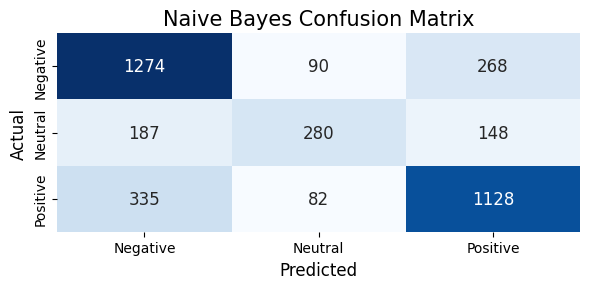

In [12]:
# Display confusion matrix for Naive Bayes prediction
conf_matrix(y_test_le, nb_pred, 'Naive Bayes Confusion Matrix')

In [13]:
# Display classification report for Naive Bayes prediction
print('\t<Classification Report for Naive Bayes>\n')
custom_report(y_test_le, nb_pred, ['Negative', 'Neutral', 'Positive'])

	<Classification Report for Naive Bayes>

              precision    recall  f1-score   support

    Negative     0.71      0.78      0.74       1632
    Neutral      0.62      0.46      0.52        615
    Positive     0.73      0.73      0.73       1545

    Accuracy     0.71



*Alright, you've achieved an accuracy of **0.71** using Naive Bayes as a first step. It's a good start! Now, let's record this and take a step forward*

## 5. BERT - Bidirectional Encoder Representations from Transformers

### 5.1 BERT Tokenization and Model Preparation


In [14]:
# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

*You might wonder why we need to tokenize the text again. The simple answer is to ensure that the input text is split into tokens that are recognizable by the BERT model.*

*BERT and similar transformer models require a specific format of input, with tokens that correspond to their pre-trained understanding of language. This step is crucial for the model to accurately interpret and process the text data.*

In [15]:
# Define max token length, 128 is the standard length
MAX_LEN = 128

# Tokenize function for datasets
def tokenize(data, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

# Tokenize training, validation, and test datasets
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

### 5.2 Load and Apply BERT

#### 5.2.1 Load the Pre-trained Model

In [16]:
# Load pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

#### 5.2.2 Model Evaluation

In [17]:
# Function to create BERT model architecture
def create_model(bert_model, max_len=MAX_LEN):
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5) # 1e-5 -> 0.00001.
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    # Defining model input layers
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    # The [1] index is used to select the pooled output for classification tasks.
    embeddings = bert_model([input_ids, attention_masks])[1]
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)

    # Define and compile the model
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])

    return model

# Create and summarize the BERT model
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

### 5.3 Model Training and testing

In [18]:
# Train the BERT model
history_bert = model.fit(
    [train_input_ids, train_attention_masks], y_train,
    validation_data=([val_input_ids, val_attention_masks], y_valid),
    epochs=3,
    batch_size=32
)

Epoch 1/3
1519/1519 [==============================] - 1332s 847ms/step - loss: 0.5543 - categorical_accuracy: 0.7788 - val_loss: 0.3530 - val_categorical_accuracy: 0.8733
Epoch 2/3
1519/1519 [==============================] - 1254s 826ms/step - loss: 0.2905 - categorical_accuracy: 0.8975 - val_loss: 0.2527 - val_categorical_accuracy: 0.9157
Epoch 3/3
1519/1519 [==============================] - 1287s 847ms/step - loss: 0.1930 - categorical_accuracy: 0.9327 - val_loss: 0.2216 - val_categorical_accuracy: 0.9281


In [19]:
# Predict using BERT model
result_bert = model.predict([test_input_ids, test_attention_masks])

# Create an array of zeros with the same shape
y_pred_bert = np.zeros_like(result_bert)
# Convert probabilities to one-hot encoded predictions using numpy advanced indexing.
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

119/119 [==============================] - 37s 283ms/step


### 5.4 Bert Result

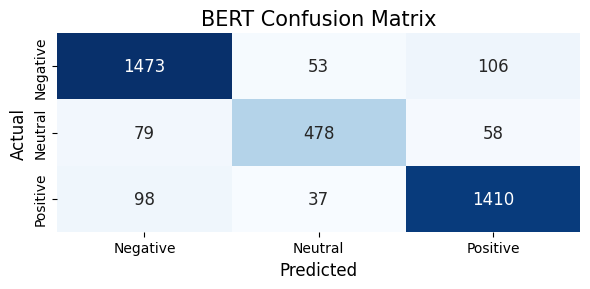

In [20]:
# Display confusion matrix for BERT model predictions
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1), 'BERT Confusion Matrix')

In [21]:
# Display classification report for BERT model predictions
print('\t<Classification Report for BERT>\n')
custom_report(y_test, y_pred_bert, ['Negative', 'Neutral', 'Positive'])

	<Classification Report for BERT>

              precision    recall  f1-score   support

    Negative     0.89      0.90      0.90       1632
    Neutral      0.84      0.78      0.81        615
    Positive     0.90      0.91      0.90       1545

    Accuracy     0.89



*Great progress!! Achieving an accuracy of **0.89** is a significant improvement and a commendable step forward from 0.70 with Naive Bayes.*

## 7. Naive Bayes Vs. BERT

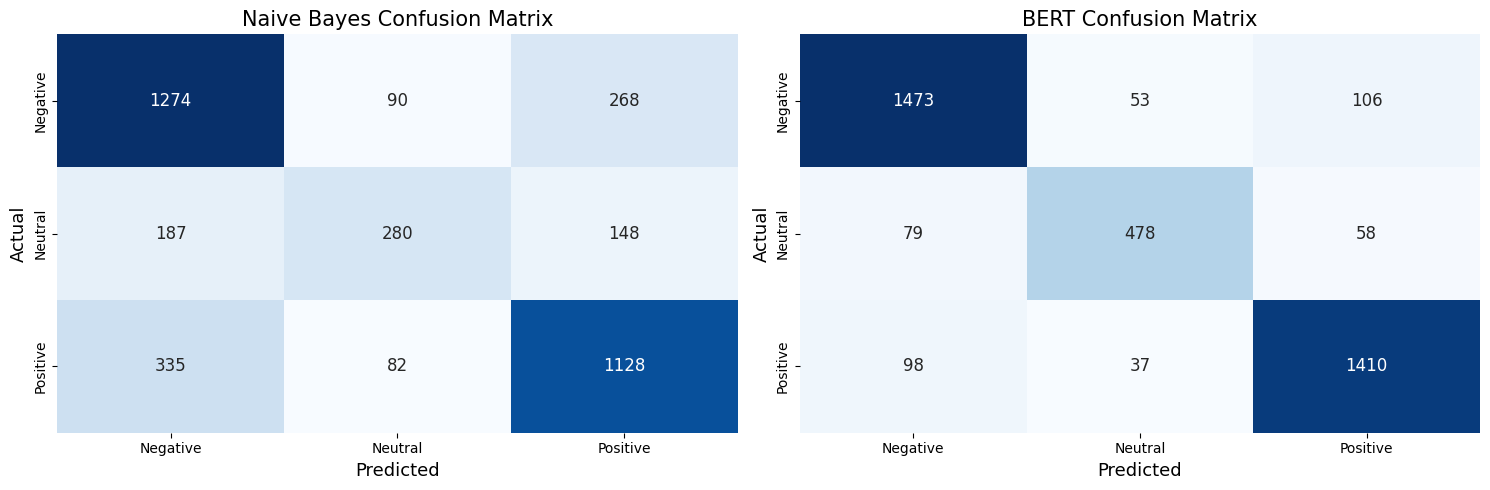

In [22]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix for Naive Bayes
conf_matrix_nb = confusion_matrix(y_test_le, nb_pred)
sns.heatmap(conf_matrix_nb, annot=True, cmap="Blues", fmt='g', cbar=False, ax=axes[0], annot_kws={"size": 12})
axes[0].set_title('Naive Bayes Confusion Matrix', fontsize=15)
axes[0].set_xticklabels(labels, fontsize=10)
axes[0].set_yticklabels(labels, fontsize=10)
axes[0].set_ylabel('Actual', fontsize=13)
axes[0].set_xlabel('Predicted', fontsize=13)

# Confusion Matrix for BERT
conf_matrix_bert = confusion_matrix(y_test.argmax(1), y_pred_bert.argmax(1))
sns.heatmap(conf_matrix_bert, annot=True, cmap="Blues", fmt='g', cbar=False, ax=axes[1], annot_kws={"size": 12})
axes[1].set_title('BERT Confusion Matrix', fontsize=15)
axes[1].set_xticklabels(labels, fontsize=10)
axes[1].set_yticklabels(labels, fontsize=10)
axes[1].set_ylabel('Actual', fontsize=13)
axes[1].set_xlabel('Predicted', fontsize=13)

# Adjust layout
plt.tight_layout()
plt.show()